# LeNet Lab
![LeNet Architecture](assets/images/lenet.png)
Source: Yan LeCun

## Summary

Train Accuracy = 98.3% and Validation Accuracy = 94.8% for V2

V3 adding -15 to 15, inc 5, 6 rotations. leet's see if validation accuracy increases. Before rotation was -10 to 10, inc 5, 4 rotations in V2. Updated learning rate = 0.001 and sigma = 0.1. Updated EPOCHS = 10 and BATCH_SIZE = 64.

Train Accuracy = 0.997

Validation Accuracy = 0.976

Test Accuracy = 0.953

## Load Data

Load the **German Traffic Sign Dataset**, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'assets/data/train.p'
validation_file='assets/data/valid.p'
testing_file= 'assets/data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
print(type(X_train))
print(len(y_train))
print(y_train)
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

<class 'numpy.ndarray'>
34799
[41 41 41 ... 25 25 25]


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

uint8
1


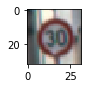

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(X_train[0].dtype)
print(y_train[index])

In [ ]:
import cv2

def display_result(orig_img, res_img, title = 'Image', show = 1):
    if show == 1:
        f, (ax1, ax2) = plt.subplots(1,2)
#         ax1.set_title('original')
        ax1.imshow(orig_img)
#         ax2.set_title('result')
        ax2.imshow(res_img)
#         f.suptitle(title)
    
def adjust_img_lightness(img, alpha = 1, beta = 20):
    """Increase brightness of image when beta > 0
       Decrease brightness of image when beta < 0
       alpha is contrast control, beta is brightness"""
    new_image = np.zeros(img.shape, img.dtype)

    # Change brightness of image by accessing the pixels
    new_image = cv2.convertScaleAbs(img, alpha = alpha, beta = beta)
    return new_image

image = X_train[285].squeeze()
bright_img = adjust_img_lightness(image, beta = 20)
dark_img = adjust_img_lightness(image, beta = -20)

display_result(image, bright_img, 'Update Img Brightness')

# plt.figure(figsize=(1,1))
# plt.imshow(s_p_img)


## Preprocess Data


Normalization on Images

In [3]:
# normalize images to ensure pixel values are between -0.5, 0.5
def normalize_images(images):
    norm_images = []
    for image in images:
        norm_img = (image / 255.0) - 0.5
        norm_images.append(norm_img)
    return norm_images
        
# data preprocessing done by tensorflow model
# normalization applied
X_train = normalize_images(X_train)
print(X_train[0].dtype)
X_valid = normalize_images(X_valid)
X_test = normalize_images(X_test)

float64


Apply **in-place data augmentation**, so our network when trained sees new variations of our data at each and every epoch. So far I augment the dataset using all flip operations on each image and rotation operations on each image.

In [4]:
import random
import cv2

def adjust_img_lightness(img, alpha = 1, beta = 20):
    """Increase brightness of image when beta > 0
       Decrease brightness of image when beta < 0
       alpha is contrast control, beta is brightness"""
    new_image = np.zeros(img.shape, img.dtype)

    # Change brightness of image by accessing the pixels
    new_image = cv2.convertScaleAbs(img, alpha = alpha, beta = beta)
    return new_image

# Add Salt and Pepper noise to image
# func: display_result(),to_std_uint8(),to_std_float(),add_salt_pepper_noise()
def display_result(orig_img, res_img, title = 'Image', show = 1):
    if show == 1:
        f, (ax1, ax2) = plt.subplots(1,2)
#         ax1.set_title('original')
        ax1.imshow(orig_img)
#         ax2.set_title('result')
        ax2.imshow(res_img)
#         f.suptitle(title)

def to_std_uint8(img):
    # Handles the conversion from float16 to uint8
    img = cv2.convertScaleAbs(img, alpha = (255/1))
    
    return img

def to_std_float(img):
    # Converts img from 0 to 1 float to avoid wrapping that occurs with uint8
    img.astype(np.float16, copy = False)
    img = np.multiply(img, (1/255))

    return img
    
# when pad is low, there is a lot more noise dots
# when pad is high, there is very little noise dots
def add_salt_pepper_noise(img, pad = 101, show = 1):
    # copy original img
    orig_img = img
    # Converts img from 0 to 1 float to avoid wrapping that occurs with uint8
    img = to_std_float(img)
    
    # Generate a set of random ints used to create s&p noise
    noise = np.random.randint(pad, size = (img.shape[0], img.shape[1], 1))

    # Convert high and low bounds of pad in noise to salt and pepper noise then
    # add it to image. 1 is subtracted from pad to match bounds behavior of
    # np.random.randint
    img = np.where(noise == 0, 0, img)
    img = np.where(noise == (pad - 1), 1, img)
    
    # Handles the conversion from float16 back to uint8
    # we now have an image with s&p noise
    res_img = to_std_uint8(img)
    
    #display_result(orig_img, res_img, 'Salt & Pepper Noise', show)
    
    return res_img

# The network has to recognize the object present in any orientation
def augment_data(images, labels):
    # initialize labels
    image_labels = []
    # initialize augmented data
    augmented_images = []
    # initialize flip image parameters
    flipped_image = None
    # initialize rotate image parameters
    rotated_image = None
    dimension = None
    (h, w) = images[0].shape[:2]
    center = (w/2, h/2)
    rot_angles = [-15, -10, -5, 5, 10, 15]
    scale = 1.0
    # initialize image translation
    # translate image at four sides retaining 87.5% of base img
    shift = [(8,8), (-8,8), (-8,-8), (8,-8)]    
    
    for image, label in zip(images, labels):
#         augmented_images.append(image)
#         image_labels.append(label)
        # 1 Add Salt and Pepper Noise to original image
#         s_p_img = add_salt_pepper_noise(image, pad = 101)
#         augmented_images.append(s_p_img)
#         image_labels.append(label)
        
        #2 Change the Brightness of the image
#         bright_img = adjust_img_lightness(image, beta = 20)
#         dark_img = adjust_img_lightness(image, beta = -20)
#         # Add brighter images to training dataset
#         augmented_images.append(bright_img)
#         image_labels.append(label)
        # Add darker images to training dataset
#         augmented_images.append(dark_img)
#         image_labels.append(label)
        
        # 3: horizontal flip
#         flipped_image = cv2.flip(image, 1)
#         augmented_images.append(flipped_image)
#         image_labels.append(label)
        
        #3 flip image: loop -1 to 1 to save all flip ops
#         for flip_op in range(-1, 2):   
#             # flip image randomly: horizontal or vertical
#             # 0: horizontal flip, 1: vertical flip, -1: Both flip
#             flipped_image = cv2.flip(image, flip_op)
#             augmented_images.append(flipped_image)
#             image_labels.append(label)
            
            #3.1 Add Salt and Pepper Noise to flipped image
#             flip_s_p_img = add_salt_pepper_noise(flipped_image, pad = 51)
#             augmented_images.append(flip_s_p_img)
#             image_labels.append(label)
        
        #4 rotated image: loop 0 to 2 to save all rotation ops
        for rot_angle in rot_angles:
            # rotate image randomly: 15 to 270 degrees counterclockwise
            M = cv2.getRotationMatrix2D(center, rot_angle, scale)
            rotated_image = cv2.warpAffine(image, M, (w, h))
            augmented_images.append(rotated_image)
            image_labels.append(label)                     
            
            #4.1 Add Salt and Pepper Noise to rotated image
#             rot_s_p_img = add_salt_pepper_noise(rotated_image, pad = 101)
#             augmented_images.append(rot_s_p_img)
#             image_labels.append(label)            
            
        #5 translate image: loop 0 to 3 to save all translations
#         for dir_op in range(0, 4):
#             # Shift object in the horizontal and vertical direction by 8 pixels
#             # retaining 75% percent of the base image
#             # [4,4] shift down and to the right by 8 pixels
#             # [-4, 4] shift up by -8 pixels and to the right 8 pixels
#             # [-4, -4] shift up by -8 pixels and to the left by -8 pixels
#             # [4, -4] shift down by 8 pixels and to the left by -8 pixels
#             quarter_height, quarter_width = h / shift[dir_op][0], w / shift[dir_op][1]

#             # create transformation matrix where [1,0,tx], tx denotes shift along x-axis,
#             # [0,1,ty], ty denotes shift along y-axis
#             T = np.float32([[1, 0, quarter_width], [0, 1, quarter_height]])

#             # We use warpAffine to transform 
#             # the image using the matrix, T 
#             translated_image = cv2.warpAffine(image, T, (w, h)) 
#             augmented_images.append(translated_image)
#             image_labels.append(label)              
            
            #5.1 Add Salt and Pepper Noise to translated image
#             tran_s_p_img = add_salt_pepper_noise(translated_image, pad = 51)
#             augmented_images.append(tran_s_p_img)
#             image_labels.append(label)             
            
    return augmented_images, image_labels

    
# Replace existing training dataset with
augmented_data, augmented_labels = [], []
augmented_data, augmented_labels = augment_data(X_train, y_train)
X_train = augmented_data
y_train = augmented_labels
print(X_train[0].shape)
# data augmentation applied using OpenCV
# X_train = cv_flip_images(X_train_original)
print(type(X_train))
print(len(X_train))
print(type(y_train))
print(len(y_train))

(32, 32, 3)
<class 'list'>
208794
<class 'list'>
208794


Shuffle the training data.

You do not need to modify this section.

In [5]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [6]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 64

## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [7]:
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x64.
    # The formula for convolutions tell us:
    # out_h = (in_h - filter_h + 1)/strides[1]
    # out_w = (in_w - filter_w + 1)/strides[2]
    # this layer has a 3x3 filter with in_depth 3 and out_depth 12
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,3,64), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(64))
    # we use conv2d to convolve the filter over the imgs and add bias at end
    conv1 = tf.nn.conv2d(x, conv1_W, strides = [1,1,1,1], padding = 'VALID') + conv1_b

    # TODO: Activation.
    # we activate the conv1 of the convolutional layer with relu activation function
    conv1 = tf.nn.relu(conv1)
    
    # TODO: Pooling. Input = 28x28x64. Output = 14x14x64.
    # we pool the conv1 using 2x2 kernel with 2x2 stride
    # filter size = 2x2
    # moves at stride of 2
    # out_h = (in_h - filter_h)/S + 1
    # out_w = (in_w - filter_w)/S + 1
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # the network then runs through another set of convolutional, activation and pooling layers outputting 5x5x16
    
    # TODO: Layer 2: Convolutional. Output = 10x10x32.
    # use same hxw dimension as conv1
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,16,32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    # move at stride of 1
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1,1,1,1], padding = 'VALID') + conv2_b
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x32.
    # filter size = 2
    # moves at stride of 2
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')  
    
    # TODO: Flatten. Input = 5x5x32. Output = 800.
    # we flatten this output into a vector, the length of the vector =  5x5x16 = 400.
    fc0 = flatten(conv2)
    
    # TODO: Layer 3: Fully Connected. Input = 800. Output = 120.
    # we pass this vector into a fully connected layer with a width of 120
    # shape=(height, width)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800,120), mean = mu, stddev = sigma))
    # tf.zeros(120) is 1D array with 120 elements that are 0
    fc1_b = tf.Variable(tf.zeros(120))
    # x*W + b
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # TODO: Activation.
    # then we apply relu to the output of the fc1
    fc1 = tf.nn.relu(fc1)

    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    # we repeat the fc again with width of 84
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    # x*W + b
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    # finally we attach a fc output layer with a width equal to the number of classes in our label set
    # in this case, we have 43 classes, one for traffic sign
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84,43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    # x*W + b
    # these outputs are also known as our logits, which is what we return from our lenet function
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [8]:
# set the batch of input imgs to none, which will allow the placeholder to later accept a batch of any size
# img dimensions are set to 32x32x1
# 1 because grayscale, if it was rgb, then 3
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
# y stores our labels, our labels come through as sparse variables, they are ints they aren't one hot encoded yet
y = tf.placeholder(tf.int32, (None))
# we use tf.one_hot function to one hot encode the labels
one_hot_y = tf.one_hot(y, 43)
# probability to keep units
keep_prob = tf.placeholder(tf.float32) 

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [9]:
# this is our training pipeline, you have to pass data into it for it to work

# we have another hyperparameter, learning rate tells tensorflow how quickly to update the networks weights
rate = 0.001
# we pass the input data to LeNet function to calculate our logits
logits = LeNet(x, keep_prob)
# we use the softmax cross entropy function to compare those logits to the ground truth labels
# and calculate the cross entropy. Cross entropy is a measure of how different the logits are
# from the ground truth labels
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# The tf.reduce_mean function averages the cross entropy from all the training imgs
loss_operation = tf.reduce_mean(cross_entropy)
# Adam optimizer uses the Adam algorithm to minimize the loss function
# Similar to the stochastic gradient descent, Adam is a little more sophisticated than it
# this is where we use the learning rate hyperparameter set earlier
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
# finally we use minimize function on the optimizer, which uses backpropagation to update the network
# and minimize our training loss
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [10]:
# Evaluate pipeline evaluates how good the model is

# the below two functions are the entire evaluation pipeline, but in order to run this
# evaluation pipeline, we have to build an evaluate function

# the first step in this pipeline is to measure whether a given prediction is correct
# by comparing the logit prediction to the one hot encoded ground truth label
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))

# the second step is to calculate the model's overall accuracy by averaging the individual
# prediction accuracies
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# this function takes a dataset as input, sets some initial variables
# then batches the dataset and runs it through the evaluation pipeline
# the evaluate function averages the accuracy of each batch to calculate the total
# accuracy of the model
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [11]:
# now everything is setup, we can build a function to train and evaluate our model
# first we create the tensorflow session and initialize the variables
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    # we train over whatever number has been set in the EPOCHS hyperparameter
    print("Training...")
    print()
    for i in range(EPOCHS):
        # at the beginning of each EPOCH, we shuffle our training data to ensure that our training isn't bias
        # by the order of the imgs
        X_train, y_train = shuffle(X_train, y_train)
        # then we break our training data into batches and train the model on each batch
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            # keep_prob = 0.5, accuracy = 94%
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        # at the end of each EPOCH, we evaluate the model on our training data
        train_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))           
            
        # at the end of each EPOCH, we evaluate the model on our validation data
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    # once we have completely trained the model we save it that way we can load it up later and modify it
    # or evaluate the model on our test dataset
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.969
Validation Accuracy = 0.936

EPOCH 2 ...
Train Accuracy = 0.984
Validation Accuracy = 0.951

EPOCH 3 ...
Train Accuracy = 0.990
Validation Accuracy = 0.965

EPOCH 4 ...
Train Accuracy = 0.995
Validation Accuracy = 0.966

EPOCH 5 ...
Train Accuracy = 0.994
Validation Accuracy = 0.969

EPOCH 6 ...
Train Accuracy = 0.996
Validation Accuracy = 0.961

EPOCH 7 ...
Train Accuracy = 0.997
Validation Accuracy = 0.971

EPOCH 8 ...
Train Accuracy = 0.997
Validation Accuracy = 0.973

EPOCH 9 ...
Train Accuracy = 0.995
Validation Accuracy = 0.964

EPOCH 10 ...
Train Accuracy = 0.997
Validation Accuracy = 0.976

Model saved


## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [12]:
# we evaluate the model on our test dataset
# we should only run the model on the test dataset one time once we are completely done with training
# otherwise we would use the test dataset to choose the best model and then the test dataset wouldn't
# provide a good estimate of how well the model would do in the real world

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.953
